# Illustrating capacity issues in SSL training

In [1]:
# Import
import math
import matplotlib.pyplot as plt
import numpy as np


# Config
np.random.seed(0)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble= r'\usepackage{mathtools}')
plt.rc('font', size=10, family='serif', serif='cm')

In [2]:
# Dataset
def halfmoon(n, noise_level=.1):
    theta = np.random.rand(n)
    theta *= 2 * np.pi
    x = np.empty((n, 2), dtype=float)
    x[:, 0] = np.cos(theta)
    x[:, 1] = np.sin(theta)
    x[x[:, 0] > 0, 1] += 1 
    x += noise_level * np.random.randn(n, 2)
    return x
    

def noise_augmentations(x, eps=.1):
    xi = np.hstack((x, x)).reshape(-1, 2)
    xi += eps * np.random.randn(*xi.shape)
    return xi

In [3]:
# Architecture
def kernel(a, b, sigma=.2):
    K = a @ b.T
    K *= 2
    K -= np.sum(a**2, axis=1)[:, np.newaxis]
    K -= np.sum(b**2, axis=1)
    K /= sigma
    np.exp(K, out=K)
    K /= a.shape[0]
    return K

In [4]:
# Training set
n = 100
x = halfmoon(n)
xi = noise_augmentations(x)

In [5]:
# Archicture
K = kernel(xi, xi, sigma=.1)

# Inverting K
thres = 1e-9
s_k, v_k = np.linalg.eigh(K)
null_eig = s_k < thres
s_k[null_eig] = 0
s_k[~null_eig] = 1 / s_k[~null_eig]
K_inv = v_k @ (v_k * s_k).T
## enforcing symmetry
K_inv += K_inv.T 
K_inv /= 2

# Testing
num = 100
X, Y = np.meshgrid(np.linspace(-1.5, 1.5, num=num), np.linspace(-1.5, 2.5, num=num))
x_test = np.vstack((X.flatten(), Y.flatten())).T
K_test = kernel(x_test, xi)
iso_test = K_test @ K_inv


# Visualization
def plot_pairs(ax, xi=xi, **kwargs):
    for i in range(xi.shape[0]//2):
        ax.plot(xi[2*i:2*(i+1), 0], xi[2*i:2*(i+1), 1], **kwargs)


def plot_level(ax, eigv, X=X, Y=Y, iso_test=iso_test, **kwargs):
    Z = iso_test @ eigv
    ax.contourf(X, Y, Z.reshape(*X.shape), **kwargs)

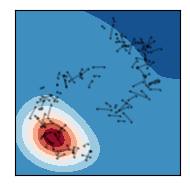

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_pairs(ax, xi, marker='.', markersize=2, c='k', alpha=.25)
plot_level(ax, v_k[:,-2], X, Y, iso_test, cmap='RdBu_r')
ax.tick_params(axis="both", which="major", labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
fig.frameon = False
fig.tight_layout()
fig.savefig('vcreg.pdf')

In [7]:
# Interplay with T
lambd = 1e-10
T = np.kron(np.eye(n), np.ones((2,2)))
s, v = np.linalg.eigh(T - lambd * K_inv)

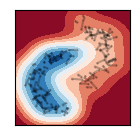

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
plot_pairs(ax, xi, marker='.', markersize=1, c='k', alpha=.25)
plot_level(ax, v[:,-1], X, Y, iso_test, cmap='RdBu_r', levels=10)
ax.tick_params(axis="both", which="major", labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
fig.frameon = False
# ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig('capacity_correct.pdf')

In [9]:
# Interplay with T
lambd = 1e-20
T = np.kron(np.eye(n), np.ones((2,2)))
s, v = np.linalg.eigh(T - lambd * K_inv)

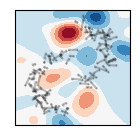

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
plot_pairs(ax, xi, marker='.', markersize=1, c='k', alpha=.25)
plot_level(ax, v[:,-1], X, Y, iso_test, cmap='RdBu_r', levels=10)
ax.tick_params(axis="both", which="major", labelleft=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
fig.frameon = False
# ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig('capacity.pdf')